In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]

In [2]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
income_df = pd.read_csv('data/income_data.csv', index_col=['Postcode'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

In [3]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

In [4]:
#take columns that are needed and update dataframes
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]
opal_df = opal_df[['date', 'mode_type', 'region','tap_on', 'tap_off']]

In [5]:
#set index
covid_df.set_index('date', inplace=True)
opal_df.set_index('date', inplace=True)

In [6]:
#sets values
opal_df.tap_on = opal_df.tap_on.str.replace(r'\D','').astype(int)
opal_df.tap_off = opal_df.tap_off.str.replace(r'\D','').astype(int)

In [7]:
#drop all rows that contain information on stations that are not needed
opal_df = opal_df[opal_df.region.isin(['Chatswood', 'Macquarie Park', 'North Sydney',  'Parramatta', 'Strathfield','Sydney CBD'])]
opal_df.reset_index(inplace=True)

In [8]:
#create opal dataframe that is grouped by day
grouped_opal = opal_df.groupby(['date', 'mode_type', 'region']).sum()
grouped_opal.reset_index(inplace=True)

In [9]:
#convert postcode to string
covid_df.postcode = covid_df.postcode.fillna(0)
covid_df.postcode = covid_df.postcode.apply(int)
covid_df.postcode = covid_df.postcode.apply(str)

In [10]:
local_covid_df = covid_df[covid_df['source'] != 'Overseas']
local_covid_df['local_tally'] = 1
local_covid_df = local_covid_df['local_tally']
local_covid_df= local_covid_df.groupby(['date']).sum()
local_covid_df

date
2020-03-02    2
2020-03-03    1
2020-03-04    4
2020-03-05    2
2020-03-06    6
             ..
2020-10-16    5
2020-10-17    1
2020-10-19    3
2020-10-20    1
2020-10-21    1
Name: local_tally, Length: 167, dtype: int64

In [11]:
#add column that includes a tally of the case
covid_df['tally'] = 1

In [12]:
#total number of cases recored each day 
covid_tally = covid_df.groupby(['date']).sum()
covid_tally

,tally
date,
2020-01-25,3
2020-01-27,1
2020-03-01,2
2020-03-02,3
2020-03-03,6
...,...
2020-10-17,6
2020-10-18,6
2020-10-19,10


In [13]:
#fill covid_tally index to include all days including days of zero recorded
#additioanlly, only include date range to match opal data
idx = pd.date_range('01-01-2020', '09-30-2020')
covid_tally = covid_tally.reindex(idx, fill_value=0)
local_covid_df = local_covid_df.reindex(idx, fill_value=0)
covid_tally.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', length=274, freq='D')

In [14]:
local_covid_df

2020-01-01    0
2020-01-02    0
2020-01-03    0
2020-01-04    0
2020-01-05    0
             ..
2020-09-26    0
2020-09-27    0
2020-09-28    0
2020-09-29    0
2020-09-30    1
Freq: D, Name: local_tally, Length: 274, dtype: int64

In [15]:
covid_tally = pd.merge(covid_tally, local_covid_df, left_index=True, right_index=True)
covid_tally

,tally,local_tally
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0
...,...,...
2020-09-26,0,0
2020-09-27,0,0
2020-09-28,5,0
2020-09-29,2,0


In [16]:
#merge dataframe 
merged_df = pd.merge(grouped_opal, covid_tally, left_on = 'date', right_index=True)
merged_df.rename(columns={'tally':'total_case_count'}, inplace=True)
merged_df = merged_df.groupby(['date', 'region']).sum()

<AxesSubplot:xlabel='date'>

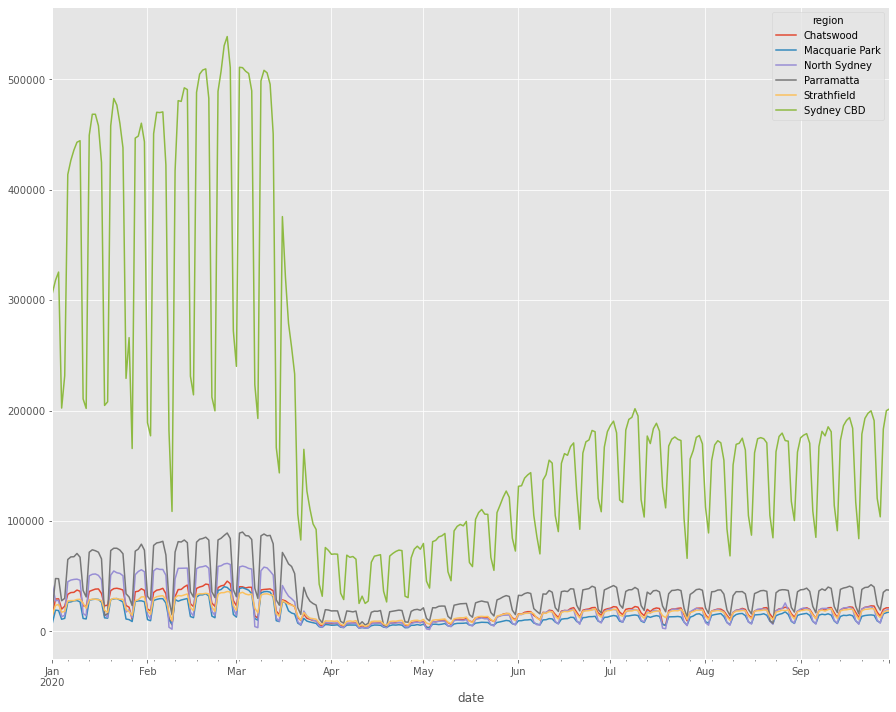

In [17]:
merged_df['tap_on'].unstack().plot()

<AxesSubplot:>

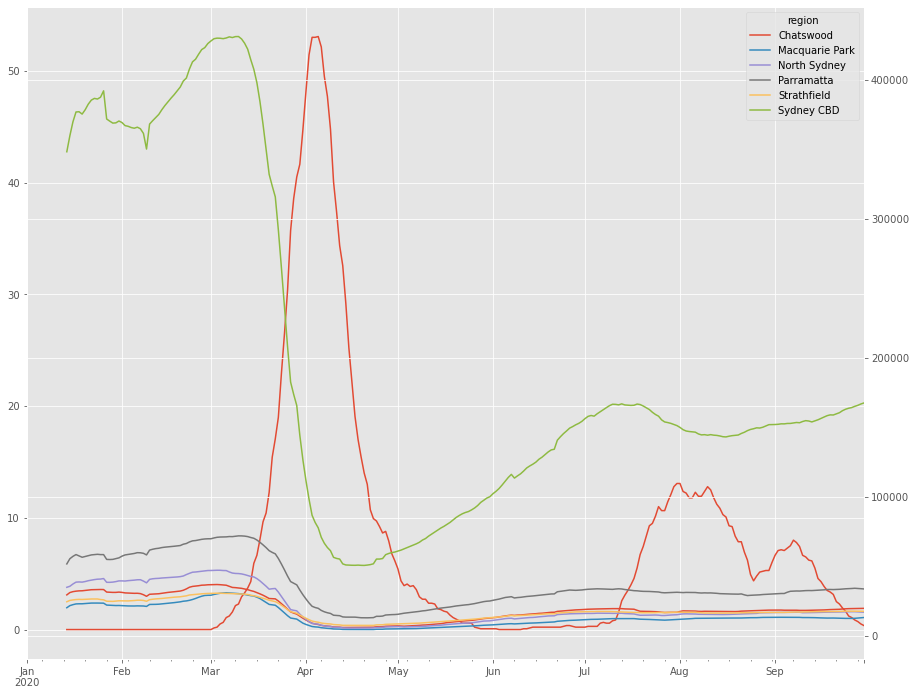

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

merged_df['tap_on'].unstack().rolling(window=14).mean().plot(ax=ax2)
local_covid_df.rolling(window=14).mean().plot(ax=ax1)

In [19]:

merged_df['combined_taps'] = merged_df.apply(lambda row: row.tap_on + row.tap_off, axis=1)

In [20]:
merged_df.head()

tap_on  tap_off  total_case_count  local_tally  \
date       region                                                           
2020-01-01 Chatswood        14600    17250                 0            0   
           Macquarie Park    7900     9850                 0            0   
           North Sydney     41500    15150                 0            0   
           Parramatta       20600    26300                 0            0   
           Strathfield      15300    19650                 0            0   

                           combined_taps  
date       region                         
2020-01-01 Chatswood               31850  
           Macquarie Park          17750  
           North Sydney            56650  
           Parramatta              46900  
           Strathfield             34950

<AxesSubplot:>

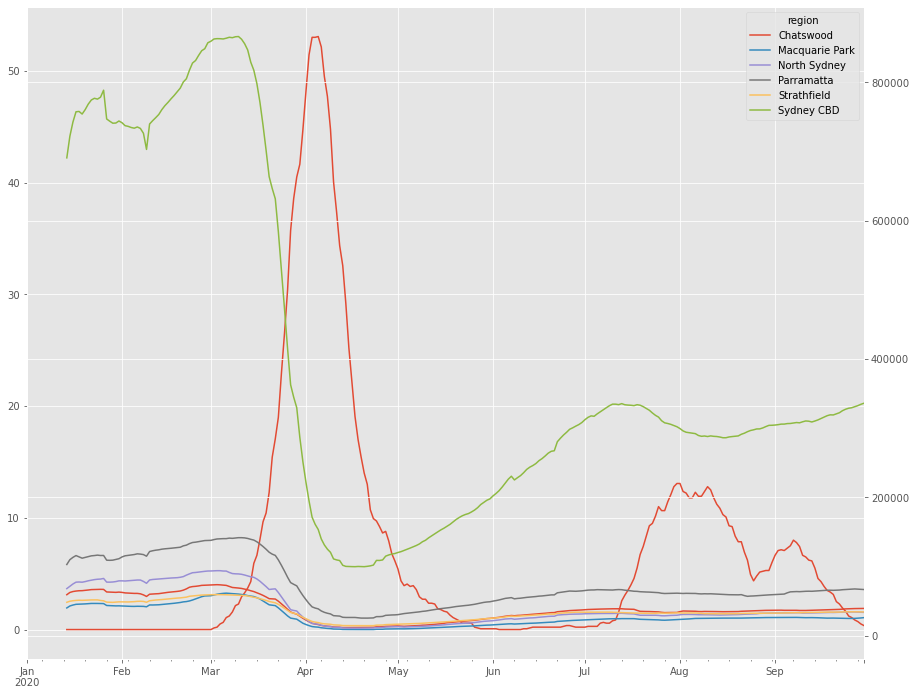

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

merged_df['combined_taps'].unstack().rolling(window=14).mean().plot(ax=ax2)
local_covid_df.rolling(window=14).mean().plot(ax=ax1)

In [22]:
rolling_avg = merged_df['combined_taps'].unstack()
rolling_avg['Metro_Total']  = rolling_avg.apply(lambda row: row.Chatswood + row['Macquarie Park'] + row['North Sydney'] + row.Parramatta + row.Strathfield + row['Sydney CBD'], axis=1)
reg_df = pd.DataFrame()
rolling_avg = rolling_avg.rolling(window=14).mean()
reg_df['taps_14_day_avg'] = rolling_avg['Metro_Total']


In [23]:
rolling_avg.head(20)

region,Chatswood,Macquarie Park,North Sydney,Parramatta,Strathfield,Sydney CBD,Metro_Total
date,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
rolling_avg_local_case = local_covid_df.rolling(window=14).mean()
rolling_avg_local_case

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
                ...   
2020-09-26    1.071429
2020-09-27    0.857143
2020-09-28    0.714286
2020-09-29    0.500000
2020-09-30    0.357143
Freq: D, Name: local_tally, Length: 274, dtype: float64

In [25]:
reg_df['local_cases_14_day_avg'] = rolling_avg_local_case
reg_df

,taps_14_day_avg,local_cases_14_day_avg
date,,
2020-01-01,NaN,NaN
2020-01-02,NaN,NaN
2020-01-03,NaN,NaN
2020-01-04,NaN,NaN
2020-01-05,NaN,NaN
...,...,...
2020-09-26,530778.571429,1.071429
2020-09-27,533042.857143,0.857143
2020-09-28,534235.714286,0.714286


In [26]:
reg_df.fillna(0,inplace=True)
reg_df.head()

,taps_14_day_avg,local_cases_14_day_avg
date,,
2020-01-01,0.0,0.0
2020-01-02,0.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0


<AxesSubplot:label='f33f38e1-0d3a-44bb-b3cf-92c122eac62d', xlabel='date'>

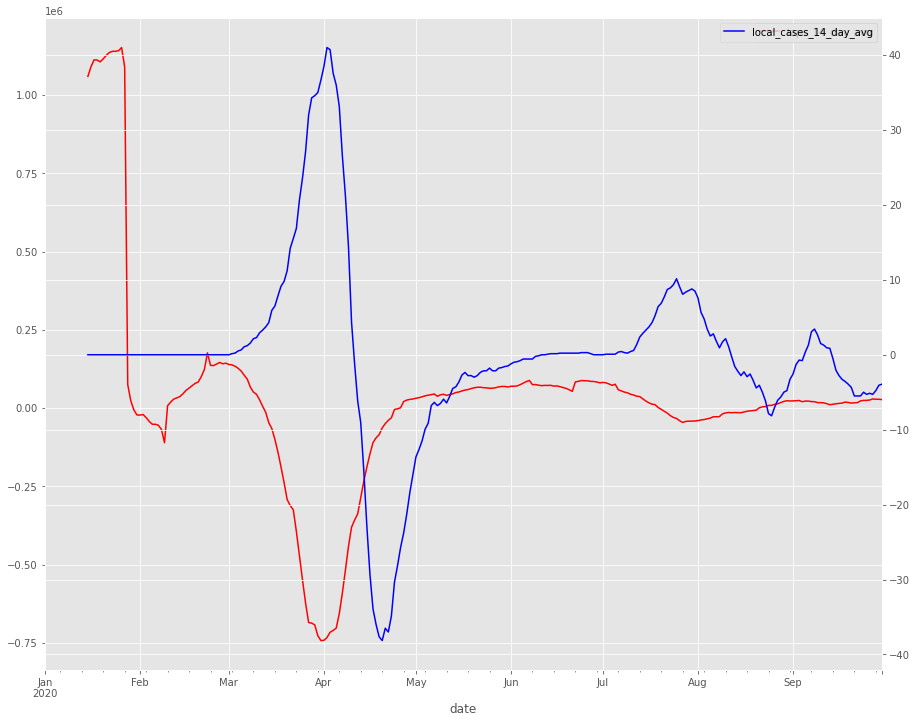

In [27]:
change_in_avg = reg_df.diff(periods=14)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
change_in_avg.plot(y='taps_14_day_avg', ax=ax1, color='red')
change_in_avg.plot(y='local_cases_14_day_avg', ax=ax2, color='blue')

In [28]:
change_in_avg.columns = ['diff_14_days_taps_avg', 'diff_14_days_local_cases_avg']
reg_df = reg_df.join(change_in_avg)

In [29]:
reg_df = reg_df.reindex(idx, fill_value=0)
reg_df.head(20)

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg
2020-01-01,0.000000e+00,0.0,NaN,NaN
2020-01-02,0.000000e+00,0.0,NaN,NaN
2020-01-03,0.000000e+00,0.0,NaN,NaN
2020-01-04,0.000000e+00,0.0,NaN,NaN
2020-01-05,0.000000e+00,0.0,NaN,NaN
2020-01-06,0.000000e+00,0.0,NaN,NaN
2020-01-07,0.000000e+00,0.0,NaN,NaN
2020-01-08,0.000000e+00,0.0,NaN,NaN
2020-01-09,0.000000e+00,0.0,NaN,NaN
2020-01-10,0.000000e+00,0.0,NaN,NaN


In [30]:
differences = [5, 7, 14, 21, 28]
for i in differences:
    change_in_case_avg = reg_df[['local_cases_14_day_avg']].diff(i)
    reg_df['diff_{}_days_local_cases_avg'.format(i)] = change_in_case_avg['local_cases_14_day_avg']

In [31]:
reg_df['taps_next_14_day_avg'] = reg_df['taps_14_day_avg'].shift(-1)
reg_df['local_cases_next_14_day_avg'] = reg_df['local_cases_14_day_avg'].shift(-1)
reg_df = reg_df[:-1]
reg_df.fillna(0, inplace=True)

In [32]:
idx = pd.date_range('01-28-2020', '09-27-2020')
reg_df = reg_df.reindex(idx, fill_value=0)

In [33]:
import math
reg_df_train = reg_df.iloc[:math.floor(reg_df.shape[0] * 0.8)]
reg_df_test = reg_df.iloc[math.floor(reg_df.shape[0] * 0.8):]

In [34]:
reg_df_train_X = reg_df_train.drop(['taps_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
reg_df_train_y = reg_df_train['taps_next_14_day_avg']
reg_df_test_X = reg_df_test.drop(['taps_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
reg_df_test_y = reg_df_test['taps_next_14_day_avg']

In [35]:
 from sklearn.neural_network import MLPRegressor

In [36]:
clf = MLPRegressor()
clf.fit(reg_df_train_X, reg_df_train_y)

MLPRegressor()

In [37]:
y_pred = clf.predict(reg_df_test_X)
accuracy = r2_score(reg_df_test_y, y_pred)
print('Accuracy: %.4f \n' % accuracy)

Accuracy: 0.9358 



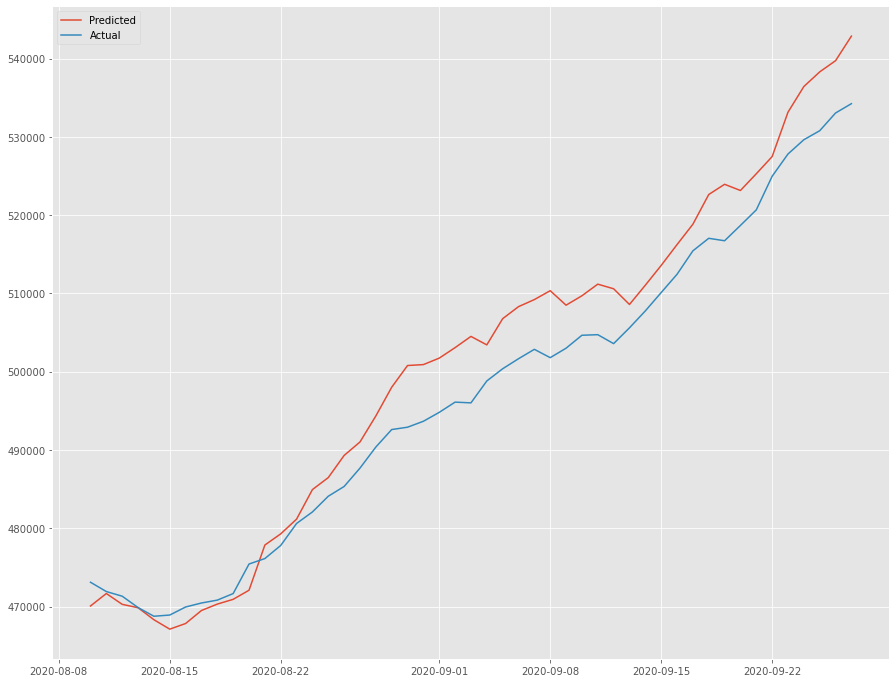

In [38]:
plt.plot(reg_df_test.index, y_pred)
plt.plot(reg_df_test.taps_next_14_day_avg)
plt.legend(['Predicted', 'Actual'])

In [39]:
cv_scores = []
cv_scores_std = []
hidden_unit_numbers = [[10],[20],[30],[40],[50],[60],[70],[80],[90],[100]]
for i in hidden_unit_numbers:
    clf_mlp = MLPRegressor(hidden_layer_sizes=i, random_state=42)
    clf_mlp.n_layers_ = 10
    clf_mlp.fit(reg_df_train_X, reg_df_train_y)
    y_pred = clf_mlp.predict(reg_df_test_X)
    scores = r2_score(reg_df_test_y, y_pred)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

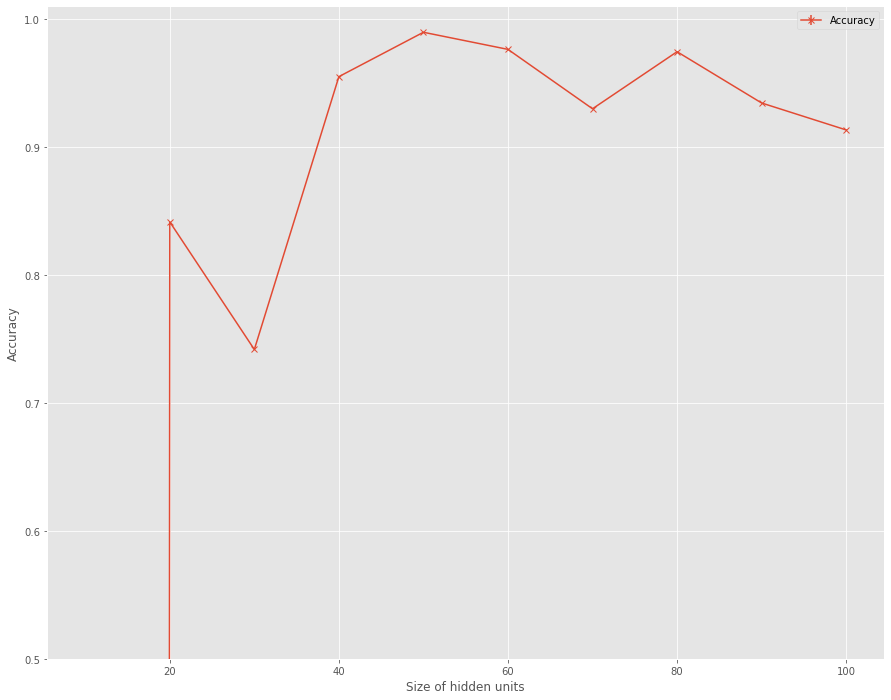

In [40]:
plt.errorbar(hidden_unit_numbers, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Size of hidden units')
plt.ylim(0.5,1.01)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [41]:
clf = MLPRegressor(hidden_layer_sizes=50, random_state=42)
clf.n_layers_ = 10
clf.fit(reg_df_train_X, reg_df_train_y)

MLPRegressor(hidden_layer_sizes=50, random_state=42)

In [42]:
y_pred = clf.predict(reg_df_test_X)
accuracy = r2_score(reg_df_test_y, y_pred)
print('Accuracy: %.4f \n' % accuracy)

Accuracy: 0.9898 



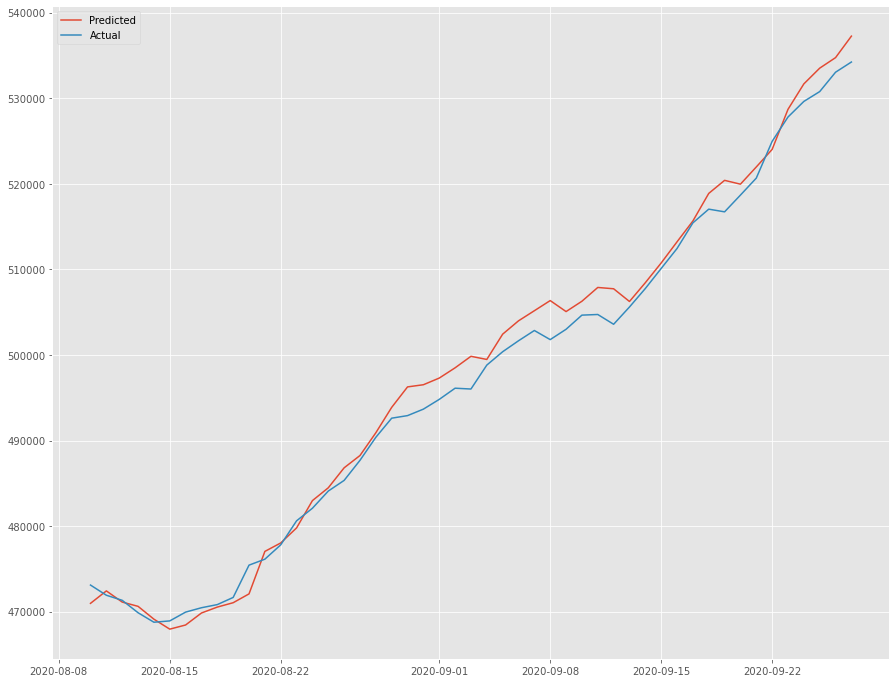

In [43]:
plt.plot(reg_df_test.index, y_pred)
plt.plot(reg_df_test.taps_next_14_day_avg)
plt.legend(['Predicted', 'Actual'])

In [44]:
reg_df_train = reg_df.iloc[:math.floor(reg_df.shape[0] * 0.8)]
reg_df_test = reg_df.iloc[math.floor(reg_df.shape[0] * 0.8):]

In [45]:
cov_df_train_X = reg_df_train.drop(['taps_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
cov_df_train_y = reg_df_train['local_cases_next_14_day_avg']
cov_df_test_X = reg_df_test.drop(['taps_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
cov_df_test_y = reg_df_test['local_cases_next_14_day_avg']
cov_df_train_y

2020-01-28     0.000000
2020-01-29     0.000000
2020-01-30     0.000000
2020-01-31     0.000000
2020-02-01     0.000000
                ...    
2020-08-05    12.285714
2020-08-06    11.928571
2020-08-07    11.928571
2020-08-08    12.357143
2020-08-09    12.785714
Freq: D, Name: local_cases_next_14_day_avg, Length: 195, dtype: float64

In [112]:
covid_model = MLPRegressor(hidden_layer_sizes=[5,8], solver = 'lbfgs', activation = 'relu', max_iter=10000, random_state=42)
covid_model.fit(cov_df_train_X, reg_df_train['local_cases_next_14_day_avg'])
reg_df_train['local_cases_next_14_day_avg']

2020-01-28     0.000000
2020-01-29     0.000000
2020-01-30     0.000000
2020-01-31     0.000000
2020-02-01     0.000000
                ...    
2020-08-05    12.285714
2020-08-06    11.928571
2020-08-07    11.928571
2020-08-08    12.357143
2020-08-09    12.785714
Freq: D, Name: local_cases_next_14_day_avg, Length: 195, dtype: float64

In [113]:
covid_predict = covid_model.predict(cov_df_test_X)
covid_predict

array([12.78251508, 12.57573056, 11.8789657 , 11.14507211, 10.81003201,
       10.17414077,  9.71315273,  8.73239103,  8.73170375,  7.89576124,
        7.52419169,  7.54455825,  6.54763303,  5.73186914,  4.43807723,
        3.70579803,  4.24317999,  4.7518996 ,  4.78280835,  5.05756244,
        5.31439514,  6.35522089,  7.14526548,  7.45748376,  7.35482461,
        7.26288241,  7.37582344,  7.51318776,  7.79776758,  7.47532957,
        6.98313933,  6.08015999,  5.95880071,  5.52673964,  5.36201122,
        4.49615314,  3.46633007,  3.34698235,  3.09756964,  2.72778941,
        2.74709515,  2.63909243,  2.25298385,  2.31436249,  1.97877127,
        1.70342709,  1.2757633 ,  1.18761599,  1.0120158 ])

In [114]:
accuracy = r2_score(cov_df_test_y, covid_predict)
print('Accuracy: %.4f \n' % accuracy)

Accuracy: 0.9760 



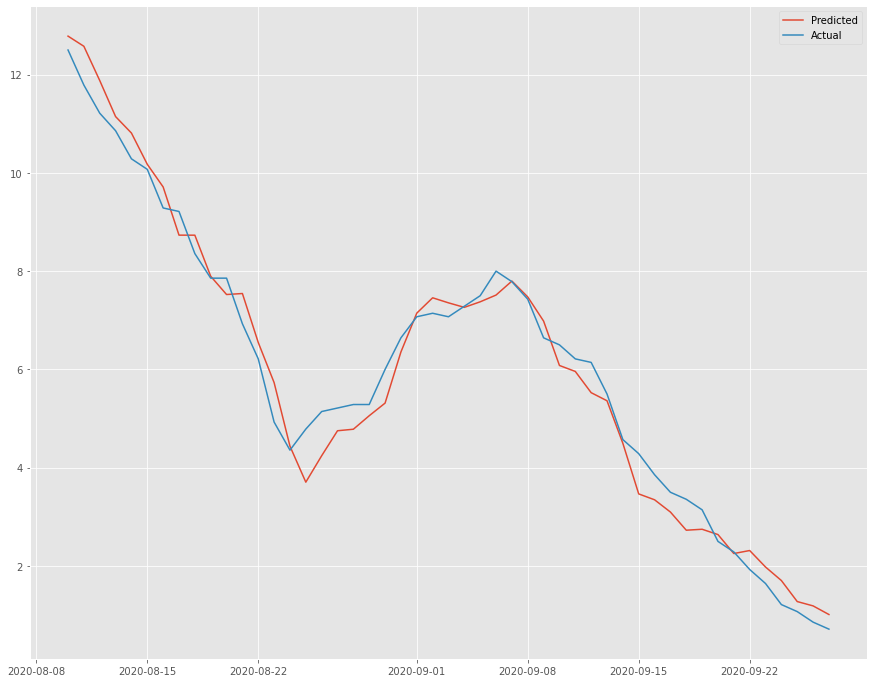

In [115]:
plt.plot(reg_df_test.index, covid_predict)
plt.plot(reg_df_test['local_cases_next_14_day_avg'])
plt.legend(['Predicted', 'Actual'])